In [79]:
%matplotlib inline

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.color_palette('winter')
sns.set()

In [80]:
%%time
# Load Data
data_dir = '../data'

with open(os.path.join(data_dir, 'prep_train.pkl'), 'rb') as f:
    train = pickle.load(f)
    
with open(os.path.join(data_dir, 'validation.pkl'), 'rb') as f:
    vals = pickle.load(f)
    
with open(os.path.join(data_dir, 'evaluation.pkl'), 'rb') as f:
    evals = pickle.load(f)

CPU times: user 28.2 s, sys: 35.6 s, total: 1min 3s
Wall time: 1min 18s


In [81]:
train.head()

,id,d,values,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price
0,HOBBIES_1_008_CA_1_validation,d_1,12,CA_1,HOBBIES_1_008,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
1,HOBBIES_1_008_CA_1_validation,d_2,15,CA_1,HOBBIES_1_008,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
2,HOBBIES_1_008_CA_1_validation,d_3,0,CA_1,HOBBIES_1_008,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
3,HOBBIES_1_008_CA_1_validation,d_4,0,CA_1,HOBBIES_1_008,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,1,0.459961
4,HOBBIES_1_008_CA_1_validation,d_5,0,CA_1,HOBBIES_1_008,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,1,0.459961


In [82]:
vals.head()

,id,d,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price
0,HOBBIES_1_001_CA_1_validation,d_1914,CA_1,HOBBIES_1_001,2016-04-25,11613,Monday,3,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
1,HOBBIES_1_001_CA_1_validation,d_1915,CA_1,HOBBIES_1_001,2016-04-26,11613,Tuesday,4,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
2,HOBBIES_1_001_CA_1_validation,d_1916,CA_1,HOBBIES_1_001,2016-04-27,11613,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
3,HOBBIES_1_001_CA_1_validation,d_1917,CA_1,HOBBIES_1_001,2016-04-28,11613,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
4,HOBBIES_1_001_CA_1_validation,d_1918,CA_1,HOBBIES_1_001,2016-04-29,11613,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38


In [83]:
evals.head()

,id,d,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price
0,HOBBIES_1_001_CA_1_evaluation,d_1942,CA_1,HOBBIES_1_001,2016-05-23,11617,Monday,3,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
1,HOBBIES_1_001_CA_1_evaluation,d_1943,CA_1,HOBBIES_1_001,2016-05-24,11617,Tuesday,4,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
2,HOBBIES_1_001_CA_1_evaluation,d_1944,CA_1,HOBBIES_1_001,2016-05-25,11617,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
3,HOBBIES_1_001_CA_1_evaluation,d_1945,CA_1,HOBBIES_1_001,2016-05-26,11617,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38
4,HOBBIES_1_001_CA_1_evaluation,d_1946,CA_1,HOBBIES_1_001,2016-05-27,11617,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0,0,8.38


In [84]:
def preprocessing(train, vals, evals):
    _train = train.copy()
    _vals = vals.copy()
    _evals = evals.copy()
    # delete columns
    del_col = ['wm_yr_wk',
               'event_name_1', 'event_type_1', 
               'event_name_2', 'event_type_2', 
               'snap_CA', 'snap_TX', 'snap_WI'
              ]
    _train.drop(del_col, axis=1, inplace=True)
    _vals.drop(del_col, axis=1, inplace=True)
    _evals.drop(del_col, axis=1, inplace=True)
    
    # Item Category
    _train['item_type'] = _train['item_id'].apply(lambda x: x.split('_')[0])
    _vals['item_type'] = _vals['item_id'].apply(lambda x: x.split('_')[0])
    _evals['item_type'] = _evals['item_id'].apply(lambda x: x.split('_')[0])
    
    # LabelEncoder
    cols = ['store_id', 'item_id', 'weekday', 'item_type']
    for c in cols:
        lbl = LabelEncoder()
        _train[c] = lbl.fit_transform(_train[c].values)
        _vals[c] = lbl.transform(_vals[c].values)
        _evals[c] = lbl.transform(_evals[c].values)
        
    # Set Category
    add_cols = ['month', 'year']
    cols.extend(add_cols)
    for c in cols:
        _train[c] = _train[c].astype('category')
        _vals[c] = _vals[c].astype('category')
        _evals[c] = _vals[c].astype('category')
        
    # Sort by Date
    _train.sort_values(by='date', ascending=True)
    del _train['date'], _vals['date'], _evals['date']
    
    return _train, _vals, _evals

In [85]:
%%time
train, vals, evals = preprocessing(train, vals, evals)

CPU times: user 2min 36s, sys: 2min 11s, total: 4min 47s
Wall time: 5min 44s


In [86]:
train.head()

,id,d,values,store_id,item_id,weekday,wday,month,year,snap,sell_price,item_type
0,HOBBIES_1_008_CA_1_validation,d_1,12,0,1444,2,1,1,2011,0,0.459961,1
1,HOBBIES_1_008_CA_1_validation,d_2,15,0,1444,3,2,1,2011,0,0.459961,1
2,HOBBIES_1_008_CA_1_validation,d_3,0,0,1444,1,3,1,2011,0,0.459961,1
3,HOBBIES_1_008_CA_1_validation,d_4,0,0,1444,5,4,2,2011,1,0.459961,1
4,HOBBIES_1_008_CA_1_validation,d_5,0,0,1444,6,5,2,2011,1,0.459961,1


In [87]:
vals.head()

,id,d,store_id,item_id,weekday,wday,month,year,snap,sell_price,item_type
0,HOBBIES_1_001_CA_1_validation,d_1914,0,1437,1,3,4,2016,0,8.38,1
1,HOBBIES_1_001_CA_1_validation,d_1915,0,1437,5,4,4,2016,0,8.38,1
2,HOBBIES_1_001_CA_1_validation,d_1916,0,1437,6,5,4,2016,0,8.38,1
3,HOBBIES_1_001_CA_1_validation,d_1917,0,1437,4,6,4,2016,0,8.38,1
4,HOBBIES_1_001_CA_1_validation,d_1918,0,1437,0,7,4,2016,0,8.38,1


In [88]:
evals.head()

,id,d,store_id,item_id,weekday,wday,month,year,snap,sell_price,item_type
0,HOBBIES_1_001_CA_1_evaluation,d_1942,0,1437,1,3,4,2016,0,8.38,1
1,HOBBIES_1_001_CA_1_evaluation,d_1943,0,1437,5,4,4,2016,0,8.38,1
2,HOBBIES_1_001_CA_1_evaluation,d_1944,0,1437,6,5,4,2016,0,8.38,1
3,HOBBIES_1_001_CA_1_evaluation,d_1945,0,1437,4,6,4,2016,0,8.38,1
4,HOBBIES_1_001_CA_1_evaluation,d_1946,0,1437,0,7,4,2016,0,8.38,1


In [89]:
train.dtypes

id              object
d               object
values           int16
store_id      category
item_id       category
weekday       category
wday              int8
month         category
year          category
snap              int8
sell_price     float16
item_type     category
dtype: object

In [90]:
vals.dtypes

id              object
d               object
store_id      category
item_id       category
weekday       category
wday             int64
month         category
year          category
snap             int64
sell_price     float64
item_type     category
dtype: object

In [91]:
evals.dtypes

id              object
d               object
store_id      category
item_id       category
weekday       category
wday             int64
month         category
year          category
snap             int64
sell_price     float64
item_type     category
dtype: object

In [140]:
class LGBMModel:
    
    def __init__(self, train, validation, evaluation, test_size=0.1):
        self.train_id = train['id'].values
        self.target = train['values'].values
        self.val_id = validation['id'].values
        self.eval_id = evaluation['id'].values
        self.val_d = validation['d'].values
        self.eval_d = evaluation['d'].values

        X = train.drop(['id', 'd', 'values'], axis=1)
        self.features = X.columns
        self.X = X.values
        self.vals = validation[self.features].values
        self.evals = evaluation[self.features].values

        self.importances = np.zeros((len(self.features)))
        self.importance_df = None
        self.best_score = 10000
        self.models = []

    def train(self, params, cv, num_boost_round=1000, early_stopping_rounds=20, verbose=200):
        print('LightGBM Model Training...')
        for i, (trn_idx, val_idx) in enumerate(cv.split(self.X)):

            train_data = lgb.Dataset(self.X[trn_idx], label=self.target[trn_idx])
            valid_data = lgb.Dataset(self.X[val_idx], label=self.target[val_idx], reference=train_data)

            model = lgb.train(params,
                              train_data,
                              valid_sets=[train_data, valid_data],
                              valid_names=['train', 'eval'],
                              num_boost_round=num_boost_round,
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=verbose
                              )
            self.models.append(model)

            self.importances += model.feature_importance() / cv.get_n_splits()

            pred = model.predict(self.X[val_idx])
            rmse = np.sqrt(mean_squared_error(y_true=self.target[val_idx], y_pred=pred))
            print(f'{i} Fold  RMSE: {rmse:.3f}')
            print('#'*30)

        self.importance_df = pd.DataFrame({
            'features': self.features,
            'importance': self.importances
        })

        return self.models, self.importance_df
    
    
    def evaluate(self):
        assert len(self.models) != 0, 'Model is not trained...'
        print('Evaluate...')
        
        pred_val = np.zeros(len(self.val_id))
        pred_eval = np.zeros(len(self.eval_id))
        
        for model in self.models:
            pred_val += model.predict(self.vals) / len(self.models)
            pred_eval += model.predict(self.evals) / len(self.models)
            
        res_val = pd.DataFrame({
            'id': self.val_id,
            'date': self.val_d,
            'pred': pred_val
        })
        
        res_eval = pd.DataFrame({
            'id': self.eval_id,
            'date': self.eval_d,
            'pred': pred_eval
        })
        
        # For submit
        print('Creating Submission')
        res = pd.DataFrame()
        F_list = [f'F{i}' for i in range(1, 29, 1)]
        # Validation
        id_list = res_val['id'].unique()
        for _id in tqdm(id_list):
            temp = res_val[res_val['id'] == _id].sort_values(by='date').reset_index(drop=True)
            temp = temp[['pred']].T.reset_index(drop=True)
            temp.columns = F_list
            temp['id'] = _id
            c = ['id'] + F_list
            temp = temp[c]
            res = pd.concat([res, temp], axis=0, ignore_index=True)
            
        # Evaluation
        id_list = res_eval['id'].unique()
        for _id in tqdm(id_list):
            temp = res_eval[res_eval['id'] == _id].sort_values(by='date').reset_index(drop=True)
            temp = temp[['pred']].T.reset_index(drop=True)
            temp.columns = F_list
            temp['id'] = _id
            c = ['id'] + F_list
            temp = temp[c]
            res = pd.concat([res, temp], axis=0, ignore_index=True)
            
        print('FINISH')
        
        return res
    
    def visualize_feature_importance(self):
        _importance_df = self.importance_df.sort_values(by='importance', ascending=False)
        fig = plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='features', data=_importance_df)
        plt.title('Feature Imporrance')
        plt.show()

In [152]:
%%time
# config
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
}

cv = KFold(n_splits=3)
num_boost_round = 10
early_stopping_rounds = 20
verbose = 5

lgbm = LGBMModel(train, vals, evals)
model, importance_df = lgbm.train(params, cv, num_boost_round, early_stopping_rounds, verbose)
res = lgbm.evaluate()

LightGBM Model Training...
Training until validation scores don't improve for 20 rounds
[5]	train's rmse: 3.91697	eval's rmse: 4.91691
[10]	train's rmse: 3.87675	eval's rmse: 4.89505
Did not meet early stopping. Best iteration is:
[10]	train's rmse: 3.87675	eval's rmse: 4.89505
0 Fold  RMSE: 4.895
##############################
Training until validation scores don't improve for 20 rounds
[5]	train's rmse: 4.54401	eval's rmse: 3.64177
[10]	train's rmse: 4.50316	eval's rmse: 3.5934
Did not meet early stopping. Best iteration is:
[10]	train's rmse: 4.50316	eval's rmse: 3.5934
1 Fold  RMSE: 3.593
##############################
Training until validation scores don't improve for 20 rounds
[5]	train's rmse: 4.30069	eval's rmse: 4.17552
[10]	train's rmse: 4.25233	eval's rmse: 4.1351
Did not meet early stopping. Best iteration is:
[10]	train's rmse: 4.25233	eval's rmse: 4.1351
2 Fold  RMSE: 4.135
##############################
Evaluate...
FINISH
CPU times: user 59min 31s, sys: 1min 50s, total: 

In [153]:
res.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028
1,HOBBIES_1_002_CA_1_validation,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028
2,HOBBIES_1_003_CA_1_validation,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028
3,HOBBIES_1_004_CA_1_validation,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028
4,HOBBIES_1_005_CA_1_validation,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028,1.351028


In [155]:
res.shape

(60980, 29)

In [156]:
res.to_csv('../data/output/submission.csv', index=False)

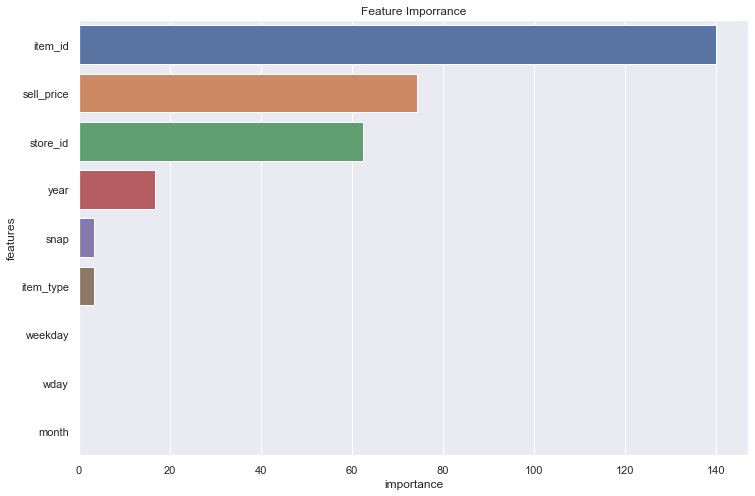

In [154]:
lgbm.visualize_feature_importance()